In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import os
import pickle

### Functions

In [2]:
def read_run_df(result_path):
    run_df = pd.read_csv(result_path)
    run_df.loc[:, 'rt'] = [np.nan if (rt == '--') or (rt == 'None') else np.float32(rt) for rt in run_df.rt]
    run_df.loc[:, 'slider_time'] = [np.nan if (time == '--') or (time == 'None') else np.float32(time) for time in run_df.slider_time]
    try: 
        run_df.loc[:, 'end_time'] = [np.nan if (time == '--') or (time == 'None') else np.float32(time) for time in run_df.end_time]
    except AttributeError:
        # for previous data version end_time is called "time"
        run_df.loc[:, 'end_time'] = [np.nan if (time == '--') or (time == 'None') else np.float32(time) for time in run_df.time]
    run_df.loc[:, 'choice'] = [np.nan if (choice == '--') or (choice == 'None') else np.float32(choice) for choice in run_df.choice]
    run_df.loc[:, 'start_ev_time'] = run_df.view_time
    run_df.loc[:, 'view_ev_duration'] = 1
    run_df.loc[:, 'eval_ev_duration'] = [rt if ~np.isnan(rt) else MAX_DURATION for rt in run_df.rt]
    run_df.loc[:, 'end_ev_time'] = run_df.slider_time + run_df.rt
    run_df.loc[:, 'ev_duration'] = [end_time-start_time if ~np.isnan(end_time) else MAX_DURATION+1
                                    for end_time, start_time in zip(run_df.end_ev_time, run_df.start_ev_time)]
    run_df.loc[run_df.lottery_id==0, 'ev_duration'] = 6 # for blank trials the duration is max = 1s viewing + 5s max RT 
    run_df.loc[:, 'EV'] = run_df.amount * run_df.prob / 100
    nas_responses = run_df[run_df.choice.isna()]

    return run_df, nas_responses

In [3]:
def sv_ev_correlation(run_df, drop_na=True):
    if drop_na:
        nas_responses = run_df[run_df.rt.isna()]
        responses_df = run_df.dropna()
    else:
        responses_df = run_df
    responses_df.choice = responses_df.choice.astype(float)
    subject_SV = run_df[['choice', 'lottery_id']].groupby('lottery_id').mean()
    sv_ev_corr = np.corrcoef(run_df.dropna().EV, run_df.dropna().choice)[0, 1]
    return sv_ev_corr

In [4]:
def write_evs_to_txt(run_df, run_i, fsf_dir):
    """
    Write EVs to txt files for each run
    """
    for i in run_df.index:
        start_str = str(run_df.loc[i, 'start_ev_time'].round(3))
        duration_str = str(run_df.loc[i, 'ev_duration'].round(3))
        ev_string = ' '.join([start_str, duration_str, '1'])
        with open(fsf_dir + f'/run{run_i}/evs/run{run_i}_ev{i+1}.txt', 'w') as f:
            f.write(ev_string)

In [5]:
def write_evs_to_txt_separated_view_eval(run_df, run_i, fsf_dir):
    """
    Write EVs to txt files for each run
    """
    i = 1
    for lottery_id in run_df.lottery_id.unique():
        lottery_df = run_df[run_df.lottery_id==lottery_id] 
        if lottery_id == 0:
            start_str = [str(np.round(start_ev_time, 3)) for start_ev_time in lottery_df.start_ev_time]
            duration_str = [str(np.round(ev_duration, 3)) for ev_duration in lottery_df.ev_duration]
            ev_string = [' '.join([start_str, duration_str, '1']) for start_str, duration_str in zip(start_str, duration_str)]
            ev_string = '\n'.join(ev_string)
            with open(fsf_dir + f'/run{run_i}/view_eval/evs_view_eval/run{run_i}_ev{i}.txt', 'w') as f:
                f.write(ev_string)
            i += 1
        else:
            view_start_str = str(np.round(lottery_df.start_ev_time.values[0], 3))
            view_duration_str = str(np.round(lottery_df.view_ev_duration.values[0], 3))
            view_ev_string = ' '.join([view_start_str, view_duration_str, '1'])
            with open(fsf_dir + f'/run{run_i}/view_eval/evs_view_eval/run{run_i}_ev{i}.txt', 'w') as f:
                f.write(view_ev_string)
            i += 1
            eval_start_str = str(np.round(lottery_df.slider_time.values[0], 3))
            eval_duration_str = str(np.round(lottery_df.eval_ev_duration.values[0], 3))
            eval_ev_string = ' '.join([eval_start_str, eval_duration_str, '1'])
            with open(fsf_dir + f'/run{run_i}/view_eval/evs_view_eval/run{run_i}_ev{i}.txt', 'w') as f:
                f.write(eval_ev_string)            
            i += 1

In [6]:
def write_evs_to_txt_unify_view(run_df, run_i, fsf_dir):
    """
    Write EVs to txt files for each run
    """
    i = 1
    for lottery_id in run_df.lottery_id.unique():
        lottery_df = run_df[run_df.lottery_id==lottery_id] 
        if lottery_id == 0:
            start_str = [str(np.round(start_ev_time, 3)) for start_ev_time in lottery_df.start_ev_time]
            duration_str = [str(np.round(ev_duration, 3)) for ev_duration in lottery_df.ev_duration]
            ev_string = [' '.join([start_str, duration_str, '1']) for start_str, duration_str in zip(start_str, duration_str)]
            ev_string = '\n'.join(ev_string)
        else:
            start_str = str(np.round(lottery_df.start_ev_time.values[0], 3))
            duration_str = str(np.round(lottery_df.view_ev_duration.values[0], 3))
            ev_string = ' '.join([start_str, duration_str, '1'])
        with open(fsf_dir + f'/run{run_i}/view/evs_view/run{run_i}_ev{i}.txt', 'w') as f:
            f.write(ev_string)
        i += 1

In [7]:
def write_evs_to_txt_unify_view_one_eval(run_df, run_i, fsf_dir):
    """
    Write EVs to txt files for each run
    """
    i = 1
    all_evals = ''
    for lottery_id in run_df.lottery_id.unique():
        lottery_df = run_df[run_df.lottery_id==lottery_id] 
        if lottery_id == 0:
            start_str = [str(np.round(start_ev_time, 3)) for start_ev_time in lottery_df.start_ev_time]
            duration_str = [str(np.round(ev_duration, 3)) for ev_duration in lottery_df.ev_duration]
            ev_string = [' '.join([start_str, duration_str, '1']) for start_str, duration_str in zip(start_str, duration_str)]
            ev_string = '\n'.join(ev_string)
        else:
            start_str = str(np.round(lottery_df.start_ev_time.values[0], 3))
            duration_str = str(np.round(lottery_df.view_ev_duration.values[0], 3))
            ev_string = ' '.join([start_str, duration_str, '1'])
            # save all evals to one string
            eval_start_str = str(np.round(lottery_df.slider_time.values[0], 3))
            eval_duration_str = str(np.round(lottery_df.eval_ev_duration.values[0], 3))
            eval_ev_string = ' '.join([eval_start_str, eval_duration_str, '1'])
            all_evals = all_evals + eval_ev_string + '\n'
        with open(fsf_dir + f'/run{run_i}/view_one_eval/evs_view_one_eval/run{run_i}_ev{i}.txt', 'w') as f:
            f.write(ev_string)
        i += 1
    # save all evals to one file
    with open(fsf_dir + f'/run{run_i}/view_one_eval/evs_view_one_eval/run{run_i}_ev{i}.txt', 'w') as f:
        f.write(all_evals)

In [8]:
def write_evs_to_txt_unify_blanks(run_df, run_i, fsf_dir):
    """
    Write EVs to txt files for each run
    """
    i = 1
    for lottery_id in run_df.lottery_id.unique():
        lottery_df = run_df[run_df.lottery_id==lottery_id] 
        if lottery_id == 0:
            start_str = [str(np.round(start_ev_time, 3)) for start_ev_time in lottery_df.start_ev_time]
            duration_str = [str(np.round(ev_duration, 3)) for ev_duration in lottery_df.ev_duration]
            ev_string = [' '.join([start_str, duration_str, '1']) for start_str, duration_str in zip(start_str, duration_str)]
            ev_string = '\n'.join(ev_string)
        else:
            start_str = str(np.round(lottery_df.start_ev_time.values[0], 3))
            duration_str = str(np.round(lottery_df.ev_duration.values[0], 3))
            ev_string = ' '.join([start_str, duration_str, '1'])
        with open(fsf_dir + f'/run{run_i}/unified_eval/evs_eval/run{run_i}_ev{i}.txt', 'w') as f:
            f.write(ev_string)
        i += 1

In [9]:
def plot_subject_stats(all_runs, subject_num):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=150)
    # choices
    axs[0].hist(all_runs.choice, color='lightcoral')
    axs[0].set_title('Choice distribution', fontsize=18)
    axs[0].set_xlabel('Choice (NIS)', fontsize=16)
    axs[0].set_xlim(-5, 85)
    axs[0].tick_params(axis='x', labelsize=13)
    axs[0].tick_params(axis='y', labelsize=13)
    # RT and misses
    n_blank_trials = len(all_runs[all_runs.amount==0])
    missed_trials = all_runs.rt.isna().sum() - n_blank_trials
    axs[1].hist(all_runs.rt, color='darkseagreen')
    axs[1].set_title(f'RT distribution (missed: {missed_trials})', fontsize=18)
    axs[1].set_xlabel('RT (s)', fontsize=16)
    axs[1].set_xlim(0, 5.5)
    axs[1].tick_params(axis='x', labelsize=13)
    axs[1].tick_params(axis='y', labelsize=13)
    # EV sensitivity
    ev_sv_corr = all_runs[['EV', 'choice']].corr().iloc[0, 1] # ignore nans
    axs[2].scatter(all_runs.EV, all_runs.choice, color='steelblue', alpha=0.5)
    axs[2].set_title(f'EV sensitivity (r={ev_sv_corr:.2f})', fontsize=18)
    axs[2].set_xlabel('EV', fontsize=16)
    axs[2].set_ylabel('Choice', fontsize=16)
    axs[2].set_ylim(-5, 85)
    axs[2].tick_params(axis='x', labelsize=13)
    axs[2].tick_params(axis='y', labelsize=13)
    plt.suptitle(f'Subject {subject_num}', fontsize=18)

### Write EVs and files

In [19]:
MAX_DURATION = 5
SUBJECT_NUM = '030'
results_dir = f'../../psychopy_version/part1/data/{SUBJECT_NUM}/'
results_path = glob.glob(results_dir + '*neuro_*.csv')
print(f'found {len(results_path)} files')

found 5 files


In [20]:
ev_ids = []
WRITE_EVS = True
EV_TYPE = 'view_unified' # 'view_unified' or 'unified_blanks' or 'org_evaluation' or 'separated_view_eval', or 'view_one_eval'
corrs = np.zeros(len(results_path))
i = 0
if WRITE_EVS:
    fsf_dir = f'/Volumes/homes/Asaf/qunex/decoy/task_analysis/{SUBJECT_NUM}'
    if not os.path.exists(fsf_dir):
            os.mkdir(fsf_dir)
df_list = []
for f in results_path:
    # extract stimuli ids
    run_i = f.split('_')[-1].split('.')[0]
    run_df, nas_responses = read_run_df(f)
    run_df.loc[:, 'run'] = run_i
    sv_ev_corr = sv_ev_correlation(run_df, drop_na=False)
    corrs[i] = run_df[['choice', 'EV']].corr().values[0, 1]
    if WRITE_EVS:
        if not os.path.isdir(fsf_dir + f'/run{run_i}/'):
            os.mkdir(fsf_dir + f'/run{run_i}/')    
        if EV_TYPE == 'view_unified':
            if not os.path.isdir(fsf_dir + f'/run{run_i}/view'):
                os.mkdir(fsf_dir + f'/run{run_i}/view')
            if not os.path.isdir(fsf_dir + f'/run{run_i}/view/evs_view/'):
                os.mkdir(fsf_dir + f'/run{run_i}/view/evs_view/')
            write_evs_to_txt_unify_view(run_df, run_i, fsf_dir)
        elif EV_TYPE == 'unified_blanks':
            if not os.path.isdir(fsf_dir + f'/run{run_i}/unified_eval'):
                os.mkdir(fsf_dir + f'/run{run_i}/unified_eval')
            if not os.path.isdir(fsf_dir + f'/run{run_i}/unified_eval/evs_eval/'):
                os.mkdir(fsf_dir + f'/run{run_i}/unified_eval/evs_eval/')
            write_evs_to_txt_unify_blanks(run_df, run_i, fsf_dir)
        elif EV_TYPE == 'org_evaluation':
            if not os.path.isdir(fsf_dir + f'/run{run_i}/evs/'):
                os.mkdir(fsf_dir + f'/run{run_i}/evs/')
            write_evs_to_txt(run_df, run_i, fsf_dir)
        elif EV_TYPE == 'separated_view_eval':
            if not os.path.isdir(fsf_dir + f'/run{run_i}/view_eval/'):
                os.mkdir(fsf_dir + f'/run{run_i}/view_eval/')
            if not os.path.isdir(fsf_dir + f'/run{run_i}/view_eval/evs_view_eval/'):
                os.mkdir(fsf_dir + f'/run{run_i}/view_eval/evs_view_eval/')
            write_evs_to_txt_separated_view_eval(run_df, run_i, fsf_dir)
        elif EV_TYPE == 'view_one_eval':
            if not os.path.isdir(fsf_dir + f'/run{run_i}/view_one_eval/'):
                os.mkdir(fsf_dir + f'/run{run_i}/view_one_eval/')
            if not os.path.isdir(fsf_dir + f'/run{run_i}/view_one_eval/evs_view_one_eval/'):
                os.mkdir(fsf_dir + f'/run{run_i}/view_one_eval/evs_view_one_eval/')
            write_evs_to_txt_unify_view_one_eval(run_df, run_i, fsf_dir)
    trial_order = np.arange(1, len(run_df)+1)
    temp_ev_id = pd.DataFrame({f'stimulus_id':run_df.lottery_id, f'ev_num_run{run_i}':trial_order})
    temp_ev_id = temp_ev_id.drop_duplicates('stimulus_id').reset_index(drop=True)
    temp_ev_id.loc[:, f'ev_num_run{run_i}'] = np.arange(1, len(temp_ev_id)+1)
    temp_ev_id.loc[temp_ev_id.stimulus_id==0, 'stimulus_id'] = 32
    # run_df.loc[run_df.lottery_id==0, 'lottery_id'] = np.arange(32, 35) # fill blank IDs with 32, 33, 34
    ev_ids.append(temp_ev_id)
    i += 1
    df_list.append(run_df)
all_runs = pd.concat(df_list)
behavior_file = f'behavior/{SUBJECT_NUM}_all_runs.csv'
if not os.path.exists(behavior_file):
    all_runs.to_csv(behavior_file, index=False)

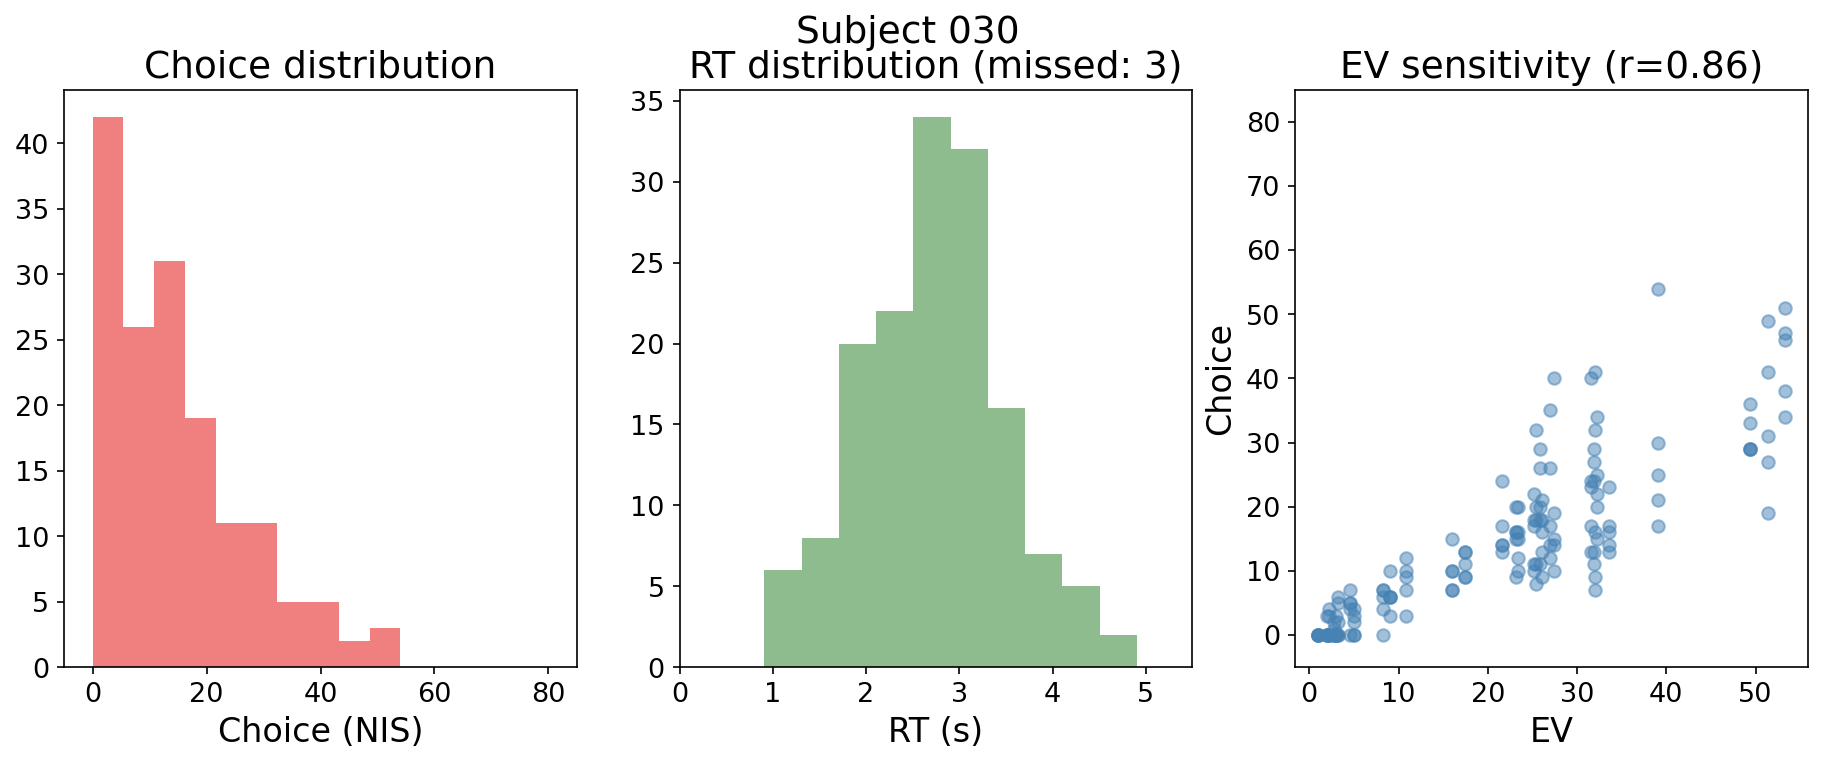

In [21]:
plot_subject_stats(all_runs, SUBJECT_NUM)

In [22]:
merged_evs = pd.DataFrame({f'stimulus_id':[]})
for ev_id_df in ev_ids:
    merged_evs = pd.merge(merged_evs, ev_id_df, on='stimulus_id', how='outer')

In [23]:
merged_evs_sorted = merged_evs.sort_values('stimulus_id').set_index('stimulus_id')

In [24]:
merged_evs_sorted

,ev_num_run4,ev_num_run5,ev_num_run2,ev_num_run1,ev_num_run3
stimulus_id,,,,,
1,20,26,30,30,27
2,32,14,1,21,4
3,9,19,12,8,1
4,30,31,3,18,8
5,10,7,29,26,20
6,8,2,16,6,15
7,16,12,2,23,10
8,24,18,21,17,22
9,7,6,18,2,23


In [25]:
merged_evs_sorted.to_csv(f'ev_data/{SUBJECT_NUM}_ev_ids.csv', float_format='%.0f')

### Edit fsf file

In [112]:
# fsf_path = 'ev_data/design_run1_hp200_s4_level1.fsf'
# # fsf_path = '/Volumes/homes/Asaf/qunex/decoy/sessions/001/hcp/001/MNINonLinear/Results/1/new_design_run1_hp200_s4_level1.fsf'
# fsf = open(fsf_path, 'r').read()

In [113]:
# for run_i in range(1, len(results_path)+1):
#     fsf_dir = f'/Volumes/homes/Asaf/qunex/decoy/task_analysis/{SUBJECT_NUM}'
#     new_fsf_path = f'{fsf_dir}/run{run_i}/design_run{run_i}_hp200_s4_level1.fsf'
#     new_fsf = fsf
#     run_evs = merged_evs_sorted.loc[:, f'ev_num_run{run_i}']
#     for stimulus_id in run_evs.index:
#         stimulus_ev = run_evs.loc[stimulus_id]
#         line_pattern = re.compile(f'set fmri\(custom{stimulus_id}\) ".*txt"')
#         line_to_replace = re.findall(line_pattern, new_fsf)[0]
#         new_line = f'set fmri(custom{stimulus_id}) "../evs/run{run_i}_ev{stimulus_ev}.txt"'
#         new_fsf = new_fsf.replace(line_to_replace, new_line)
#         new_fsf = new_fsf.replace("MNINonLinear/Results/1/1", f"MNINonLinear/Results/{run_i}/{run_i}")
#         new_fsf = new_fsf.replace("001", SUBJECT_NUM)
#     if not os.path.exists(fsf_dir):
#         os.mkdir(fsf_dir)
#     open(new_fsf_path, f'w').write(new_fsf)
    

#### view+bdm unified blanks

In [114]:
if EV_TYPE == 'unified_blanks':
    fsf_path = 'ev_data/unified_blank_run1_hp200_s4_level1.fsf'
    fsf = open(fsf_path, 'r').read()
    for run_i in range(1, len(results_path)+1):
        fsf_dir = f'/Volumes/homes/Asaf/qunex/decoy/task_analysis/{SUBJECT_NUM}'
        new_fsf_path = f'{fsf_dir}/run{run_i}/unified_eval/eval_run{run_i}_hp200_s4_level1.fsf'
        new_fsf = fsf
        run_evs = merged_evs_sorted.loc[:, f'ev_num_run{run_i}']
        for stimulus_id in run_evs.index:
            stimulus_ev = run_evs.loc[stimulus_id]
            line_pattern = re.compile(f'set fmri\(custom{stimulus_id}\) ".*txt"')
            line_to_replace = re.findall(line_pattern, new_fsf)[0]
            new_line = f'set fmri(custom{stimulus_id}) "../evs_eval/run{run_i}_ev{stimulus_ev}.txt"'
            new_fsf = new_fsf.replace(line_to_replace, new_line)
            new_fsf = new_fsf.replace("MNINonLinear/Results/1/1", f"MNINonLinear/Results/{run_i}/{run_i}")
            new_fsf = new_fsf.replace("006", SUBJECT_NUM)
        if not os.path.exists(fsf_dir):
            os.mkdir(fsf_dir)
        open(new_fsf_path, f'w').write(new_fsf)
    

#### only view

In [26]:
if EV_TYPE == 'view_unified':
    fsf_path = 'ev_data/unified_blank_run1_hp200_s4_level1.fsf'
    fsf = open(fsf_path, 'r').read()
    for run_i in range(1, len(results_path)+1):
        fsf_dir = f'/Volumes/homes/Asaf/qunex/decoy/task_analysis/{SUBJECT_NUM}'
        new_fsf_path = f'{fsf_dir}/run{run_i}/view/view_unified_run{run_i}_hp200_s4_level1.fsf'
        new_fsf = fsf
        run_evs = merged_evs_sorted.loc[:, f'ev_num_run{run_i}']
        for stimulus_id in run_evs.index:
            stimulus_ev = run_evs.loc[stimulus_id]
            line_pattern = re.compile(f'set fmri\(custom{stimulus_id}\) ".*txt"')
            line_to_replace = re.findall(line_pattern, new_fsf)[0]
            new_line = f'set fmri(custom{stimulus_id}) "../evs_view/run{run_i}_ev{stimulus_ev}.txt"'
            new_fsf = new_fsf.replace(line_to_replace, new_line)
            new_fsf = new_fsf.replace("MNINonLinear/Results/1/1", f"MNINonLinear/Results/{run_i}/{run_i}")
            new_fsf = new_fsf.replace("006", SUBJECT_NUM)
        if not os.path.exists(fsf_dir):
            os.mkdir(fsf_dir)
        open(new_fsf_path, f'w').write(new_fsf)
    

#### view and one evaluation EV

In [ ]:
if EV_TYPE == 'view_one_eval':
    fsf_path = 'ev_data/view_one_eval_run1_hp200_s4_level1.fsf'
    fsf = open(fsf_path, 'r').read()
    for run_i in range(1, len(results_path)+1):
        fsf_dir = f'/Volumes/homes/Asaf/qunex/decoy/task_analysis/{SUBJECT_NUM}'
        new_fsf_path = f'{fsf_dir}/run{run_i}/view_one_eval/view_one_eval_run{run_i}_hp200_s4_level1.fsf'
        new_fsf = fsf
        run_evs = merged_evs_sorted.loc[:, f'ev_num_run{run_i}']
        for stimulus_id in run_evs.index:
            stimulus_ev = run_evs.loc[stimulus_id]
            line_pattern = re.compile(f'set fmri\(custom{stimulus_id}\) ".*txt"')
            line_to_replace = re.findall(line_pattern, new_fsf)[0]
            new_line = f'set fmri(custom{stimulus_id}) "../evs_view_one_eval/run{run_i}_ev{stimulus_ev}.txt"'
            new_fsf = new_fsf.replace(line_to_replace, new_line)
            new_fsf = new_fsf.replace("MNINonLinear/Results/1/1", f"MNINonLinear/Results/{run_i+1}/{run_i+1}")
            new_fsf = new_fsf.replace("006", SUBJECT_NUM)
        # ev for all evals 33 (last)
        stimulus_id = 33
        stimulus_ev = 33
        line_pattern = re.compile(f'set fmri\(custom{stimulus_id}\) ".*txt"')
        line_to_replace = re.findall(line_pattern, new_fsf)[0]
        new_line = f'set fmri(custom{stimulus_id}) "../evs_view_one_eval/run{run_i}_ev{stimulus_ev}.txt"'
        new_fsf = new_fsf.replace(line_to_replace, new_line)
        new_fsf = new_fsf.replace("MNINonLinear/Results/1/1", f"MNINonLinear/Results/{run_i+1}/{run_i+1}")
        new_fsf = new_fsf.replace("006", SUBJECT_NUM)
        if not os.path.exists(fsf_dir):
            os.mkdir(fsf_dir)
        open(new_fsf_path, f'w').write(new_fsf)
    

#### separated view and evaluation EVs

In [ ]:
def replace_line_in_ev_file(id, ev, new_fsf, run_i):
    line_pattern = re.compile(f'set fmri\(custom{id}\) ".*txt"')
    line_to_replace = re.findall(line_pattern, new_fsf)[0]
    new_line = f'set fmri(custom{id}) "../evs_view_eval/run{run_i}_ev{ev}.txt"'
    new_fsf = new_fsf.replace(line_to_replace, new_line)
    return new_fsf

In [ ]:
view_evs = merged_evs_sorted * 2 - 1
eval_evs = merged_evs_sorted * 2
blank_evs = view_evs.loc[32]
view_evs = view_evs - (view_evs > blank_evs) # after blank condition the count shifts by 1
eval_evs = eval_evs - (eval_evs > blank_evs) # after blank condition the count shifts by 1

In [ ]:
if EV_TYPE == 'separated_view_eval':
    fsf_path = 'ev_data/view_eval_template.fsf'
    fsf = open(fsf_path, 'r').read()
    for run_i in range(1, len(results_path)+1):
        fsf_dir = f'/Volumes/homes/Asaf/qunex/decoy/task_analysis/{SUBJECT_NUM}'
        new_fsf_path = f'{fsf_dir}/run{run_i}/view_eval/view_eval_run{run_i}_hp200_s4_level1.fsf'
        new_fsf = fsf
        # add all other conditions
        for stimulus_id in view_evs.index:
            stimulus_ev = merged_evs_sorted.loc[stimulus_id, f'ev_num_run{run_i}']
            view_ev = view_evs.loc[stimulus_id, f'ev_num_run{run_i}']
            view_id = stimulus_id * 2 - 1
            new_fsf = replace_line_in_ev_file(view_id, view_ev, new_fsf, run_i)
            if stimulus_id != 32: # if not blank
                eval_ev = eval_evs.loc[stimulus_id, f'ev_num_run{run_i}']
                eval_id = stimulus_id * 2
                new_fsf = replace_line_in_ev_file(eval_id, eval_ev, new_fsf, run_i)
        new_fsf = new_fsf.replace("MNINonLinear/Results/1/1", f"MNINonLinear/Results/{run_i+1}/{run_i+1}") # run directories start from 2 (run1 is in Results/2/)
        new_fsf = new_fsf.replace("006", SUBJECT_NUM)
        if not os.path.exists(fsf_dir):
            os.mkdir(fsf_dir)
        open(new_fsf_path, f'w').write(new_fsf)
    